from google.colab import drive
drive.mount('/content/drive')

In [4]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pylab import *
import json
import h5py
import imageio.v2 as imageio
from IPython.display import Image
import os

import glob
import matplotlib.pyplot as plt
#from tifffile import imsave
import h5py

import skimage

import sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical



# GPU check. If Num GPUs Availalbe: is 0, check runtime connection

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

In [1]:
pwd

'/Volumes/MX500_1TB/GitHub/Projects/TEM_seg'

In [2]:
HOME_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train"
IMG_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/img/"
MSK_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/msk/"

#Data Augmentation Path
AUG_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/aug/"

SUB_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/sub_img/"
TRAIN_DATA_DIR = ""
VALID_DATA_DIR = ""
TEST_DATA_DIR = ""

In [5]:
IMG_list = os.listdir(IMG_DIR)
MSK_list = os.listdir(MSK_DIR)
IMG_list = sorted(IMG_list)
MSK_list = sorted(MSK_list)

print(IMG_list)
print(MSK_list)

print(len(IMG_list))
print(len(MSK_list))

['E1-60000X-1.tif', 'E1-60000X-16.tif', 'E1-60000X-2.tif', 'E1-60000X-3.tif', 'E1-60000X-37.tif', 'E1-60000X-38.tif', 'E1-60000X-4.tif', 'E1-60000X-5.tif', 'E1-60000X-58.tif', 'E1-60000X-59.tif', 'E1-60000X-6.tif', 'E1-60000X-7.tif', 'E1-60000X-8.tif', 'X2248-60000X-1.tif', 'X2248-60000X-2.tif', 'X2248-60000X-5.tif']
['Label_E1-60000X-1.png', 'Label_E1-60000X-16.png', 'Label_E1-60000X-2.png', 'Label_E1-60000X-3.png', 'Label_E1-60000X-37.png', 'Label_E1-60000X-38.png', 'Label_E1-60000X-4.png', 'Label_E1-60000X-5.png', 'Label_E1-60000X-58.png', 'Label_E1-60000X-59.png', 'Label_E1-60000X-6.png', 'Label_E1-60000X-7.png', 'Label_E1-60000X-8.png', 'Label_X2248-60000X-1.png', 'Label_X2248-60000X-2.png', 'Label_X2248-60000X-5.png']
16
16


In [6]:
img=np.array(imageio.imread(IMG_DIR+IMG_list[0]))
msk=np.array(imageio.imread(MSK_DIR+MSK_list[0]))

In [10]:
for i in range(len(IMG_list)):
    img=np.array(imageio.imread(IMG_DIR+IMG_list[i]))
    msk=np.array(imageio.imread(MSK_DIR+MSK_list[i]))
    print(f"image file name is: {IMG_list[i]}, label file name is: {MSK_list[i]}")
    print(f"image shape is {img.shape}, label shape is {msk.shape}")
print(img.shape)
print(np.max(img))
print(msk.shape)
print(np.max(msk))

image file name is: E1-60000X-1.tif, label file name is: Label_E1-60000X-1.png
image shape is (1024, 1024), label shape is (1024, 1024)
image file name is: E1-60000X-16.tif, label file name is: Label_E1-60000X-16.png
image shape is (1024, 1024), label shape is (1024, 1024)
image file name is: E1-60000X-2.tif, label file name is: Label_E1-60000X-2.png
image shape is (1024, 1024), label shape is (1024, 1024)
image file name is: E1-60000X-3.tif, label file name is: Label_E1-60000X-3.png
image shape is (1024, 1024), label shape is (1024, 1024)
image file name is: E1-60000X-37.tif, label file name is: Label_E1-60000X-37.png
image shape is (1024, 1024), label shape is (1024, 1024)
image file name is: E1-60000X-38.tif, label file name is: Label_E1-60000X-38.png
image shape is (1024, 1024), label shape is (1024, 1024)
image file name is: E1-60000X-4.tif, label file name is: Label_E1-60000X-4.png
image shape is (1024, 1024), label shape is (1024, 1024)
image file name is: E1-60000X-5.tif, label

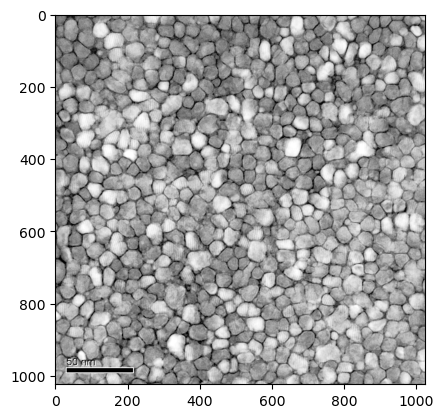

In [8]:
plt.imshow(img, cmap = 'Greys')

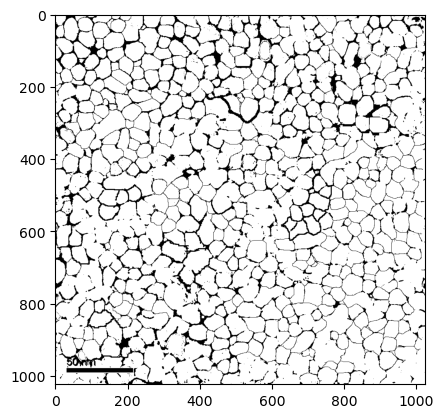

In [8]:
plt.imshow(msk, cmap ='gray', vmin=0, vmax=1)

In [12]:
import numpy as np

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


## Get Equally Sliced Sub-image, Size(256,256)

In [13]:
orig_x = 1024
orig_y = 1024

step_x = 128
step_y = 128

output_x = 256
output_y = 256
num_classes = 2

for i in range(0, len(IMG_list)):
    filename = IMG_list[i]
    #print(filename)
    img=np.array(imageio.imread(IMG_DIR + IMG_list[i]))
    if img.shape == (1024,1024,3):
        img = rgb2gray(img)
    
    msk=np.array(imageio.imread(MSK_DIR + MSK_list[i]))
    img_scale=scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)

    print(f"image file name is: {IMG_list[i]}, label file name is: {MSK_list[i]}")

    # Initialize features and labels with `None`
    X = None
    Y = None

    for x in range(0, orig_x-output_x+1, step_x):
        for y in range(0, orig_y-output_y+1, step_y):

                start_x = x
                start_y = y

                Y = np.copy(msk[start_x: start_x + output_x,
                                start_y: start_y + output_y])
                #Y = keras.utils.to_categorical(Y, num_classes=num_classes)

                X = np.copy(img_scale[start_x: start_x + output_x,
                                start_y: start_y + output_y])

                    # change dimension of X
                    # from (x_dim, y_dim, z_dim, num_channels)
                    # to (num_channels, x_dim, y_dim, z_dim)
                X = np.expand_dims(X, axis=0)
                Y = np.expand_dims(Y, axis=0)

                    # change dimension of y
                    # from (x_dim, y_dim, z_dim, num_classes)
                    # to (num_classes, x_dim, y_dim, z_dim)
                #Y = np.moveaxis(Y, 3, 0)

                    #excludes the background class
                #Y = Y[:, :, :]

                file=filename \
                +"_x_"+str(start_x) \
                +"_y_"+str(start_y) \
                +"_"

                destination = os.path.join("/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/sub_img/", f"{file}.h5")

                if os.path.exists(destination):
                    # File already exists, do something
                    pass

                else:
                    os.makedirs(os.path.dirname(destination), exist_ok= True)
                    with h5py.File(destination, "w") as f1:
                        dset1 = f1.create_dataset("x", (output_x, output_y), dtype='float32', data=X)
                        dset2 = f1.create_dataset("y", (output_x, output_y), dtype='uint8', data=Y)
                        f1.close()
print("Done")

image file name is: E1-60000X-1.tif, label file name is: Label_E1-60000X-1.png
image file name is: E1-60000X-16.tif, label file name is: Label_E1-60000X-16.png
image file name is: E1-60000X-2.tif, label file name is: Label_E1-60000X-2.png
image file name is: E1-60000X-3.tif, label file name is: Label_E1-60000X-3.png
image file name is: E1-60000X-37.tif, label file name is: Label_E1-60000X-37.png
image file name is: E1-60000X-38.tif, label file name is: Label_E1-60000X-38.png
image file name is: E1-60000X-4.tif, label file name is: Label_E1-60000X-4.png
image file name is: E1-60000X-5.tif, label file name is: Label_E1-60000X-5.png
image file name is: E1-60000X-58.tif, label file name is: Label_E1-60000X-58.png
image file name is: E1-60000X-59.tif, label file name is: Label_E1-60000X-59.png
image file name is: E1-60000X-6.tif, label file name is: Label_E1-60000X-6.png
image file name is: E1-60000X-7.tif, label file name is: Label_E1-60000X-7.png
image file name is: E1-60000X-8.tif, label

## Get Random Sub-Image, Size(256,256)

In [ ]:
def get_random_sub_image(img, msk, filename = None,
                   orig_x = 1024, orig_y = 1024, 
                   output_x = 256, output_y = 256,
                   max_tries = 10):

    # Initialize features and labels with `None`
    X = None
    Y = None

    tries = 0

    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0, orig_x - output_x+1)
        start_y = np.random.randint(0, orig_y - output_y+1)

        # extract relevant area of label
        Y = np.copy(msk[start_x: start_x + output_x,
                        start_y: start_y + output_y])

        tries += 1

        # make copy of the sub-volume
        X = np.copy(img[start_x: start_x + output_x,
                        start_y: start_y + output_y])

        file=filename \
            +"_random" \
            +"_x_"+str(start_x) \
            +"_y_"+str(start_y) \
            +"_z_"


        return X, Y, file

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-image. Giving up...")

In [ ]:
output_x = 80
output_y = 80
output_z = 64

for i in range(0, len(MRI_list)):
    file_name = MRI_list[i]
    img=np.array(nib.load(HeadMRI_DIR + MRI_list[i]).get_fdata())
    msk=np.array(nib.load(Headlabel_DIR + Label_list[i]).get_fdata())
    img_scale=scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    #Reshape to 240x240x192
    #img = img_scale[0:240, 5:245, :]
    #msk = msk[0:240, 5:245, :]

    count = 0

    while count < 25:

        X, Y , file = get_random_sub_image(image = img_scale, label = msk, filename=file_name, brain_ratio=0.8)


        destination = os.path.join("D:/DataSet/HeadSeg/Raw_HeadSet", f"{file}.h5")

        if os.path.exists(destination):
            # File already exists, do something
            pass

        else:
            os.makedirs(os.path.dirname(destination), exist_ok= True)
            with h5py.File(destination, "w") as f1:
                dset1 = f1.create_dataset("x", (1, output_x, output_y, output_z), dtype='float64', data=X)
                dset2 = f1.create_dataset("y", (5, output_x, output_y, output_z), dtype='uint8', data=Y)
                f1.close()

        count += 1

In [ ]:
def get_sub_volume(image, label, filename,
                   orig_x = 256, orig_y = 256, orig_z = 192,
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 6, max_tries = 1000,
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image,
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label.
            labels coded using discrete values rather than
            a separate dimension,
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    tries = 0
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0, orig_x - output_x+1)
        start_y = np.random.randint(0, orig_y - output_y+1)
        start_z = np.random.randint(0, orig_z - output_z+1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]

        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        # compute the background ratio
        background_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if background_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z])

            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            #X = np.moveaxis(X, 3, 0)
            X = np.expand_dims(X, axis=0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, 3, 0)

            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]

            file=filename \
                +"x"+str(start_x) \
                +"y"+str(start_y) \
                +"z"+str(start_z)

            return X, y, file

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")


# set home directory and data directory
#HOME_DIR = "./BraTS-Data/"
HOME_DIR = "/Users/mwshay/Library/CloudStorage/OneDrive-UNSW/ThesisProject/jupyternotebook/Headset_Data/"
MRI_DIR = HOME_DIR + "MRI/"
LABEL_DIR = HOME_DIR + "Label/"

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())

    return image, label

def standardize(image):
    """
    Standardize mean and standard deviation
        of each channel and z_dimension.

    Args:
        image (np.array): input image,
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)
    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)

            # divide by the standard deviation (only if it is different from zero)
            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)

                # update  the slice of standardized image
                # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

In [16]:
import os
import json


def get_file_names(path):
    files = []
    for filename in os.listdir(path):
        if os.path.isfile(os.path.join(path, filename)):
            files.append(filename)
    return files

train_files = get_file_names(SUB_DIR)
#valid_files = get_file_names(Valid_DIR)
#config = {"train": train_files,"valid":valid_files}
config = {"train": train_files}
print(config)

SAVE_DIR = HOME_DIR
os.chdir(SAVE_DIR)

with open('config.json', 'w') as f:
    json.dump(config, f)
    f.close()

print("Done")

{'train': ['X2248-60000X-2.tif_x_384_y_768_.h5', 'E1-60000X-1.tif_x_256_y_512_.h5', 'E1-60000X-38.tif_x_512_y_640_.h5', 'E1-60000X-2.tif_x_768_y_128_.h5', 'X2248-60000X-5.tif_x_256_y_384_.h5', 'E1-60000X-4.tif_x_384_y_512_.h5', 'E1-60000X-58.tif_x_128_y_128_.h5', 'E1-60000X-1.tif_x_640_y_512_.h5', 'X2248-60000X-5.tif_x_640_y_0_.h5', 'X2248-60000X-5.tif_x_640_y_384_.h5', 'E1-60000X-58.tif_x_768_y_0_.h5', 'E1-60000X-16.tif_x_768_y_0_.h5', 'E1-60000X-2.tif_x_640_y_128_.h5', 'E1-60000X-7.tif_x_384_y_128_.h5', 'E1-60000X-5.tif_x_128_y_640_.h5', 'E1-60000X-3.tif_x_512_y_256_.h5', 'E1-60000X-3.tif_x_640_y_0_.h5', 'E1-60000X-2.tif_x_256_y_128_.h5', 'X2248-60000X-5.tif_x_768_y_384_.h5', 'E1-60000X-58.tif_x_512_y_512_.h5', 'E1-60000X-6.tif_x_512_y_640_.h5', 'E1-60000X-1.tif_x_768_y_512_.h5', 'X2248-60000X-1.tif_x_384_y_384_.h5', 'X2248-60000X-1.tif_x_0_y_384_.h5', 'X2248-60000X-2.tif_x_384_y_0_.h5', 'E1-60000X-38.tif_x_384_y_128_.h5', 'E1-60000X-5.tif_x_384_y_512_.h5', 'E1-60000X-59.tif_x_128_y_